In [59]:
import pandas as pd
import math
from random import sample 
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('./models/')

import ease 
import pretty_plotter
import main_metrics

## Datasets EDA 

### 1. InstaCart Data 

In [3]:
order_products_train_df = pd.read_csv("./data/instacart/order_products__train.csv")[
    ['order_id', 'product_id']].rename({'product_id': 'good_foreign_id'}, axis = 1)

In [4]:
order_products_train_df.head(3)
print(order_products_train_df.shape)

(1384617, 2)


<Axes: >

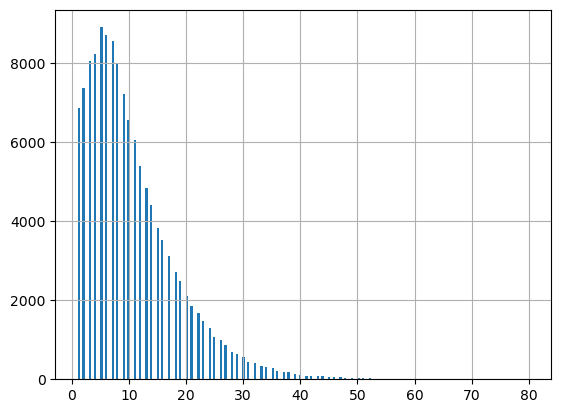

In [101]:
order_products_train_df.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10-15 items in them

In [6]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['order_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [7]:
single_items_baskets = return_indexes_to_drop(order_products_train_df)

In [8]:
instacart = order_products_train_df[~order_products_train_df.index.isin(single_items_baskets)]
instacart.shape

(1381791, 2)

In [9]:
#as there is no time data - we re splitting the datasets quaterly - 3/4 - train, 1/4 - test 
train_data = instacart[:1038462]
test_data =  instacart[~instacart.index.isin(train_data.index)]

In [10]:
train_data.shape, test_data.shape

((1038462, 2), (343329, 2))

In [17]:
def mask_values(lst, num):
    curr_lst = lst.copy()  
    new_list = sample(curr_lst, len(curr_lst) - num)
    return new_list

In [28]:
def create_masked_sample(df): 
    
    grouped_items = pd.DataFrame(df.groupby(['order_id']).agg(list).good_foreign_id).reset_index()
    grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))
    grouped_items['num_to_mask'] = grouped_items['lists_len'].apply(lambda x: math.ceil(x * 0.2))
    grouped_items['lists_to_pred'] = grouped_items.apply(lambda row: mask_values(row['good_foreign_id'], 
                                                                                 row['num_to_mask']), axis=1)
    grouped_items = grouped_items[['order_id', 'good_foreign_id', 'lists_len', 'num_to_mask',
           'lists_to_pred']].explode('lists_to_pred')

    masked_data = grouped_items[['order_id','lists_to_pred']
                               ].rename({'lists_to_pred': 'good_foreign_id'}, axis = 1)
    
    return masked_data, grouped_items

In [29]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)
#we gonna use masked_data for test and them joined stats from test_data_with_masked_stats for validation

In [32]:
train_data = train_data.sample(50000)

In [33]:
pred_dataset_instacart = ease.recommend_items(train_data, masked_data, 'order_id', 'good_foreign_id', top_n = 20)

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32390/32390 [00:46<00:00, 698.10it/s]


Recommendations generated.


In [36]:
pred_dataset_instacart.head(3)

,order_id,basket,vector,recs,preds
0,2573810,"[32398, 33672, 14992, 23540]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."
1,2573833,"[21903, 20339, 13176, 35547, 22035]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."
2,2573894,[46804],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."


In [46]:
evaluation_df = test_data_with_masked_stats[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred_dataset_instacart).rename({'good_foreign_id': 'original_basket', 
                                                                    'basket': 'masked_basket'}, axis = 1)

In [47]:
evaluation_df.head(3)

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds
0,2573810,"[23540, 33672, 32398, 6101, 14992]",1,"[32398, 33672, 14992, 23540]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."
1,2573810,"[23540, 33672, 32398, 6101, 14992]",1,"[32398, 33672, 14992, 23540]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."
2,2573810,"[23540, 33672, 32398, 6101, 14992]",1,"[32398, 33672, 14992, 23540]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0, 8076, 8077, 8078, 8079, 8080, 8081, 8082,...","[14, 2951, 1727, 4175, 2437, 1171, 3804, 7244,..."


In [48]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()

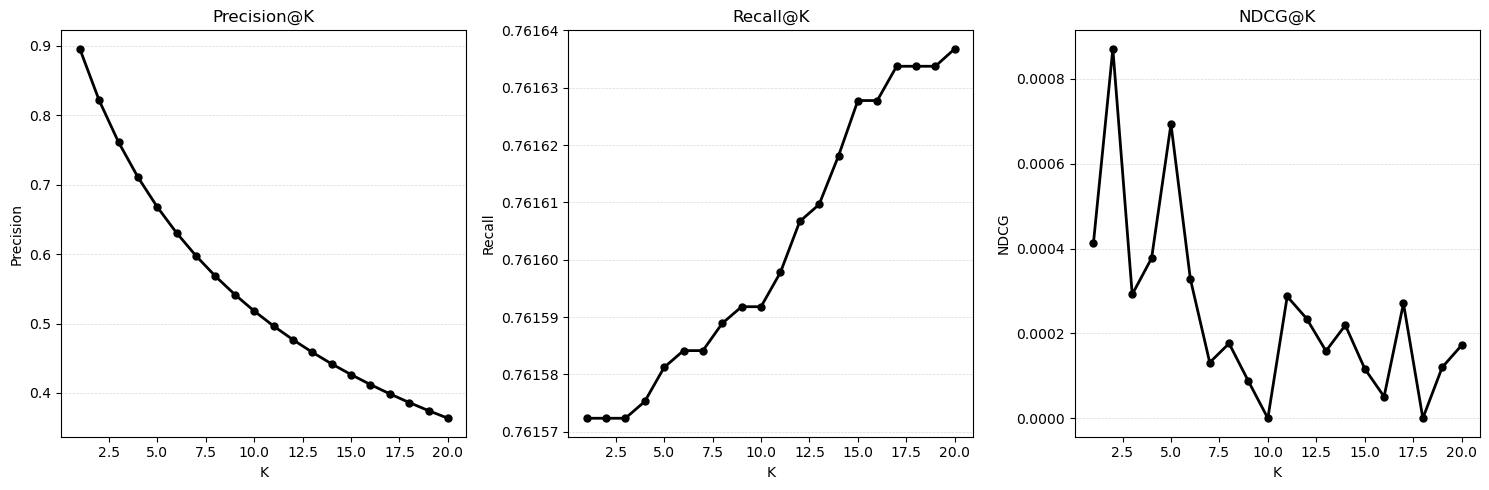

In [55]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [53]:
top_n_list = order_products_train_df.good_foreign_id.value_counts()[:20].index.tolist()

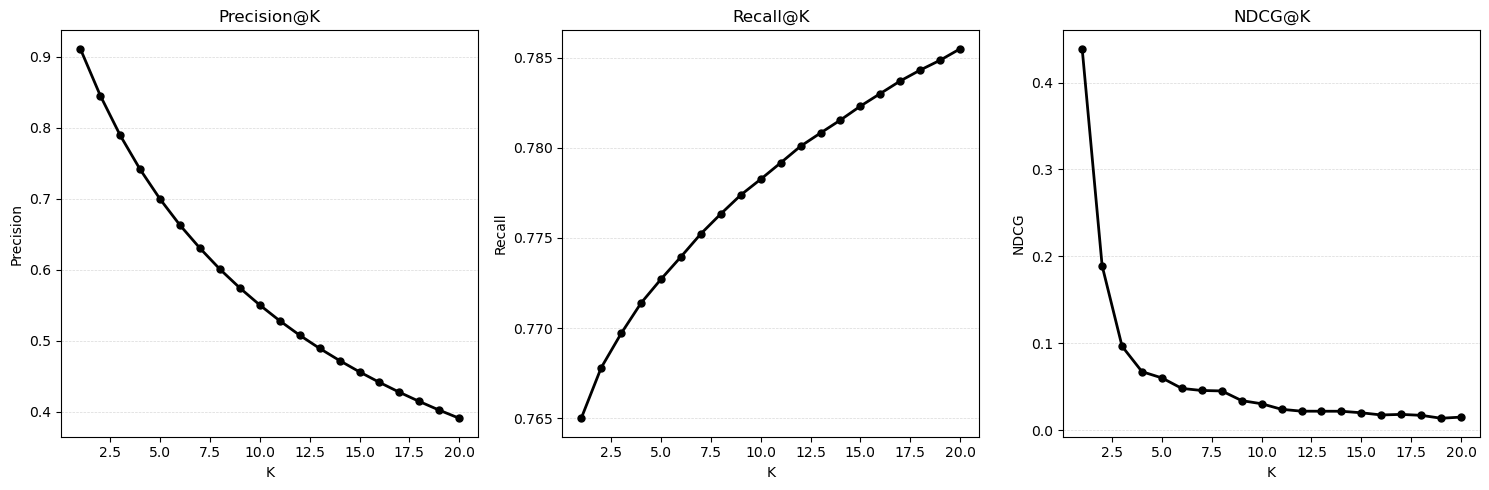

In [54]:
main_metrics.calculate_precision_recall_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
main_metrics.calculate_and_save_ndcg_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_for_top_n_metrics)

### 2. Ta Feng Dataset

In [72]:
ta_feng_dataset = pd.read_csv('./data/ta_feng_all_months_merged.csv')[
    ['TRANSACTION_DT', 'CUSTOMER_ID', 'PRODUCT_ID']]

In [73]:
ta_feng_dataset.TRANSACTION_DT = ta_feng_dataset.TRANSACTION_DT .apply(lambda x: x.replace('/', '-'))

ta_feng_dataset.TRANSACTION_DT = [datetime.strptime(date, '%m-%d-%Y').strftime('%Y-%m-%d') for date in ta_feng_dataset.TRANSACTION_DT]

In [77]:
df = ta_feng_dataset.rename({'TRANSACTION_DT': 'date', 'CUSTOMER_ID': 'customer_id', 
                               'PRODUCT_ID': 'good_foreign_id'}, axis = 1)

In [75]:
df.shape

(817741, 3)

In [78]:
def return_indexes_to_drop(df): 
    baskets_dataset = df.groupby(['customer_id']).agg(list)
    baskets_dataset['baskets_size'] = baskets_dataset.good_foreign_id.apply(lambda x: len(x))
    
    drop_indexes = baskets_dataset[baskets_dataset.baskets_size == 1].index.to_list()
    
    return drop_indexes

In [79]:
single_items_baskets = return_indexes_to_drop(df)

te_feng = df[~df.index.isin(single_items_baskets)]
te_feng.shape

(817501, 3)

In [80]:
def labelling_order_id(df):
    
    #setting order id as its not impicitly mentioned in original data 
    #we count order id as label of basket of items for users puchases within a certain day

    grouped = df.groupby(['date', 'customer_id'])
    df['order_id'] = grouped.ngroup() + 1
    
    return df

labelling_order_id(df).head(3)

,date,customer_id,good_foreign_id,order_id
0,2000-11-01,1104905,4710199010372,78
1,2000-11-01,418683,4710857472535,34
2,2000-11-01,1057331,4710043654103,75


<Axes: >

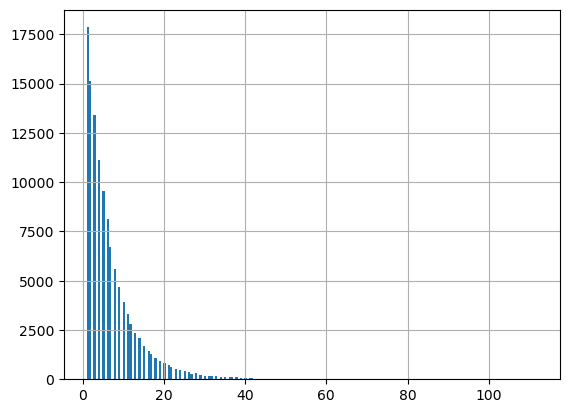

In [100]:
df.groupby(['order_id']).good_foreign_id.agg(list).apply(lambda x: len(x)).hist(bins = 200)
#left-sided distribution - most of the baskets represented in the datasets contain less then 10 items

In [81]:
def split_train_test(group, time_threshold):
    
    train = group[group['date'] <= time_threshold]
    test = group[group['date'] > time_threshold]
    
    
    return train,test

In [82]:
time_threshold = '2000-11-06'

train_data, test_data = zip(*df.groupby('order_id').apply(split_train_test, 
                                                                 time_threshold=time_threshold))

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [83]:
masked_data, test_data_with_masked_stats = create_masked_sample(test_data)

In [84]:
pred_dataset_te_feng = ease.recommend_items(train_data, masked_data, 'order_id', 'good_foreign_id', top_n = 20)

Creating index mappings...
Index mappings created.
Creating sparse matrix...
Sparse matrix created.
Fitting EASE...
EASE fitted.
Generating user vectors...
User vectors generated.
Generating recommendations...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113424/113424 [02:29<00:00, 758.10it/s]


Recommendations generated.


In [85]:
evaluation_df = test_data_with_masked_stats[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred_dataset_te_feng).rename({'good_foreign_id': 'original_basket', 
                                                                    'basket': 'masked_basket'}, axis = 1)

In [86]:
classic_prec_rec_metrics = evaluation_df.copy()

classic_prec_rec_for_top_n_metrics = evaluation_df.copy()

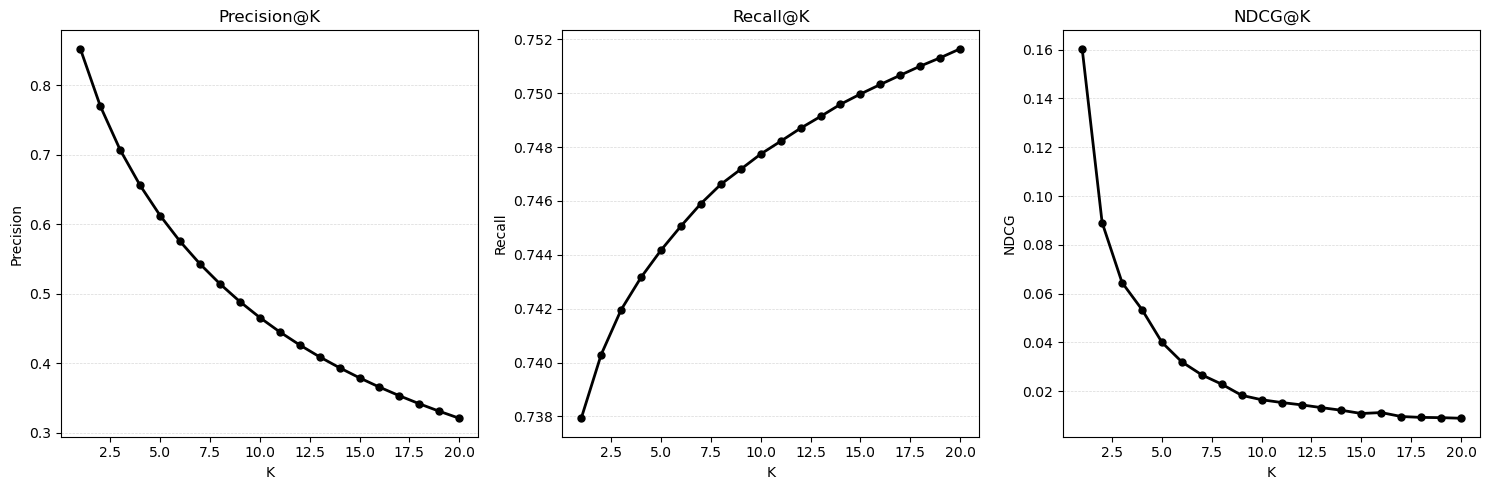

In [87]:
main_metrics.calculate_and_save_precision_recall(classic_prec_rec_metrics)
main_metrics.calculate_and_save_ndcg(classic_prec_rec_metrics)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_metrics)

In [88]:
top_n_list = te_feng.good_foreign_id.value_counts()[:20].index.tolist()

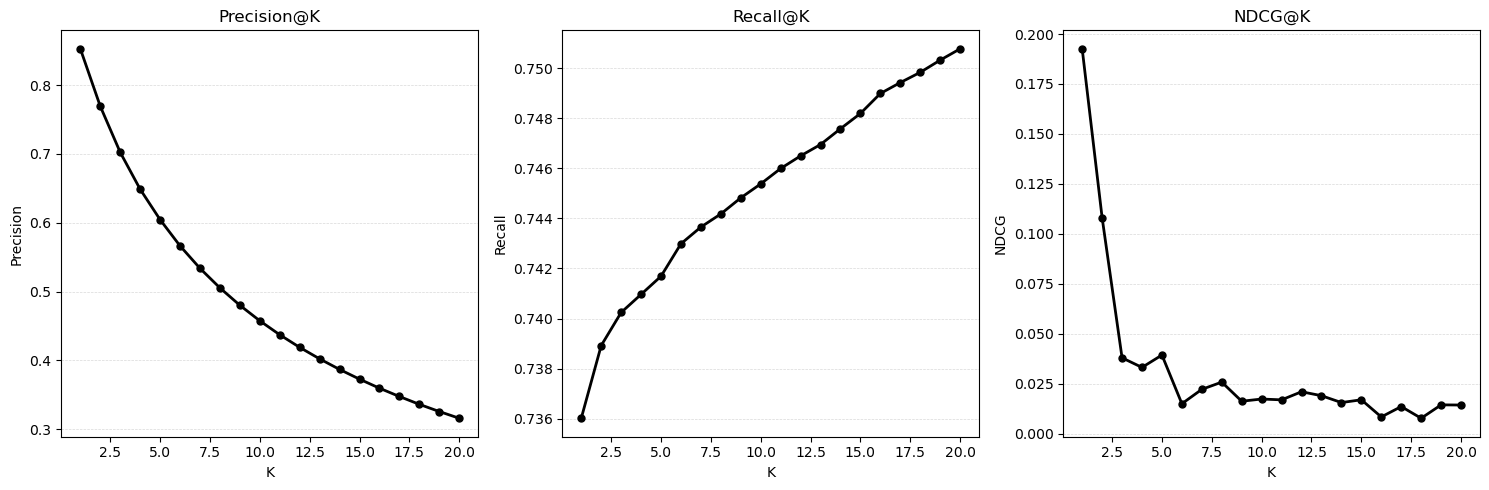

In [89]:
main_metrics.calculate_precision_recall_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
main_metrics.calculate_and_save_ndcg_top_n_items(classic_prec_rec_for_top_n_metrics, top_n_list)
pretty_plotter.plot_pretty_metrics(classic_prec_rec_for_top_n_metrics)